# Artificial Neural Networks and Deep Learning - Homework 1















- Team: Bio.log(y)







- Members: Luca Lepore, Arianna Rigamonti, Michele Sala, Jacopo Libero Tettamanti















---















## Baseline model with regularization on pre-processed data

### ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

# Import other libraries
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from ipywidgets import interact, IntSlider, Dropdown
from tensorflow.keras.utils import to_categorical
import plotly.express as px
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

TensorFlow version: 2.16.1
Keras version: 3.3.3


## ⏳ Load Data

In [ ]:
# Load dataset
train_augmented = np.load('/kaggle/input/images2/X_train_augmented_3x.npz')
X_train = train_augmented['images']
y_train = train_augmented['labels']

val_augmented = np.load('/kaggle/input/images2/X_val_augmented_3x.npz')
X_val = val_augmented['images']
y_val = val_augmented['labels']

test = np.load('/kaggle/input/images2/X_test.npz')
X_test = test['images']
y_test = test['labels']

test_augmented = np.load('/kaggle/input/images2/X_test_augmented_4x.npz')
X_test_augmented = test_augmented['images']
y_test_augmented = test_augmented['labels']

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Save unique labels
unique_labels = list(labels.values())
print(f'Unique labels: {unique_labels}')

Unique labels: ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [3]:
# Check the shape of the loaded images
print(f"Loaded X_train images shape: {X_train.shape}")
print(f"Loaded y_train labels shape: {y_train.shape}")
print(f"Min value X_train: {X_train.min()}, Max value X_train: {X_train.max()}\n")

print(f"Loaded X_val images shape: {X_val.shape}")
print(f"Loaded y_val labels shape: {y_val.shape}")
print(f"Min value X_val: {X_val.min()}, Max value X_val: {X_val.max()}\n")

print(f"Loaded X_test images shape: {X_test.shape}")
print(f"Loaded y_test labels shape: {y_test.shape}")
print(f"Min value X_test: {X_test.min()}, Max value X_test: {X_test.max()}\n")

print(f"Loaded X_test_augmented images shape: {X_test_augmented.shape}")
print(f"Loaded y_test_augmented labels shape: {y_test_augmented.shape}")
print(f"Min value X_test_augmented: {X_test_augmented.min()}, Max value X_test_augmented: {X_test_augmented.max()}")

Loaded X_train images shape: (21513, 96, 96, 3)
Loaded y_train labels shape: (21513, 8)
Min value X_train: 0.0, Max value X_train: 255.0

Loaded X_val images shape: (7173, 96, 96, 3)
Loaded y_val labels shape: (7173, 8)
Min value X_val: 0.0, Max value X_val: 255.0

Loaded X_test images shape: (2391, 96, 96, 3)
Loaded y_test labels shape: (2391, 8)
Min value X_test: 0, Max value X_test: 255

Loaded X_test_augmented images shape: (9564, 96, 96, 3)
Loaded y_test_augmented labels shape: (9564, 8)
Min value X_test_augmented: 0.0, Max value X_test_augmented: 255.0


In [4]:
# Flatten the labels to class indices since they're in one-hot encoding
y_train_flat = np.argmax(y_train, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class weights:")
for class_index, weight in class_weight_dict.items():
    print(f"Class {class_index}: Weight {weight:.2f}")

Class weights:
Class 0: Weight 1.75
Class 1: Weight 0.69
Class 2: Weight 1.38
Class 3: Weight 0.74
Class 4: Weight 1.76
Class 5: Weight 1.50
Class 6: Weight 0.64
Class 7: Weight 0.91


## 🧮 Define Network Parameters

In [5]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [6]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 64

# Learning rate
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 64


## 🛠️ Build the Model

In [7]:
# Define the CNN model with regularization
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed
):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the model architecture layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    # First convolutional layer
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
    x = tfkl.BatchNormalization(name='bn1')(x)  # Batch Normalization
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)
    x = tfkl.Dropout(0.3, name='dropout1')(x)  # Dropout with rate 0.3

    # Second convolutional layer
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)  # Batch Normalization
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)
    x = tfkl.Dropout(0.3, name='dropout2')(x)  # Dropout with rate 0.3

    # Flatten layer
    x = tfkl.Flatten(name='flatten')(x)

    # Fully connected dense layer
    x = tfkl.Dense(units=128, activation='relu', name='dense1')(x)  # Additional dense layer with activation
    x = tfkl.BatchNormalization(name='bn3')(x)  # Batch Normalization
    x = tfkl.Dropout(0.4, name='dropout3')(x)  # Dropout with rate 0.4

    # Output layer
    x = tfkl.Dense(units=output_shape, name='dense2')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='regularized_CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

Model: "regularized_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ bn1 (BatchNormalization)    │ (None, 96, 96, 32)    │        128 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout1 (Dropout)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ bn2 (BatchNormalization)    │ (None, 48, 48, 64)    │        256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout2 (Dropout)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense1 (Dense)              │ (None, 128)           │  4,718,720 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ bn3 (BatchNormalization)    │ (None, 128)           │        512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout3 (Dropout)          │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense2 (Dense)              │ (None, 8)             │      1,032 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 4,740,040 (18.08 MB)

 Trainable params: 4,739,592 (18.08 MB)

 Non-trainable params: 448 (1.75 KB)

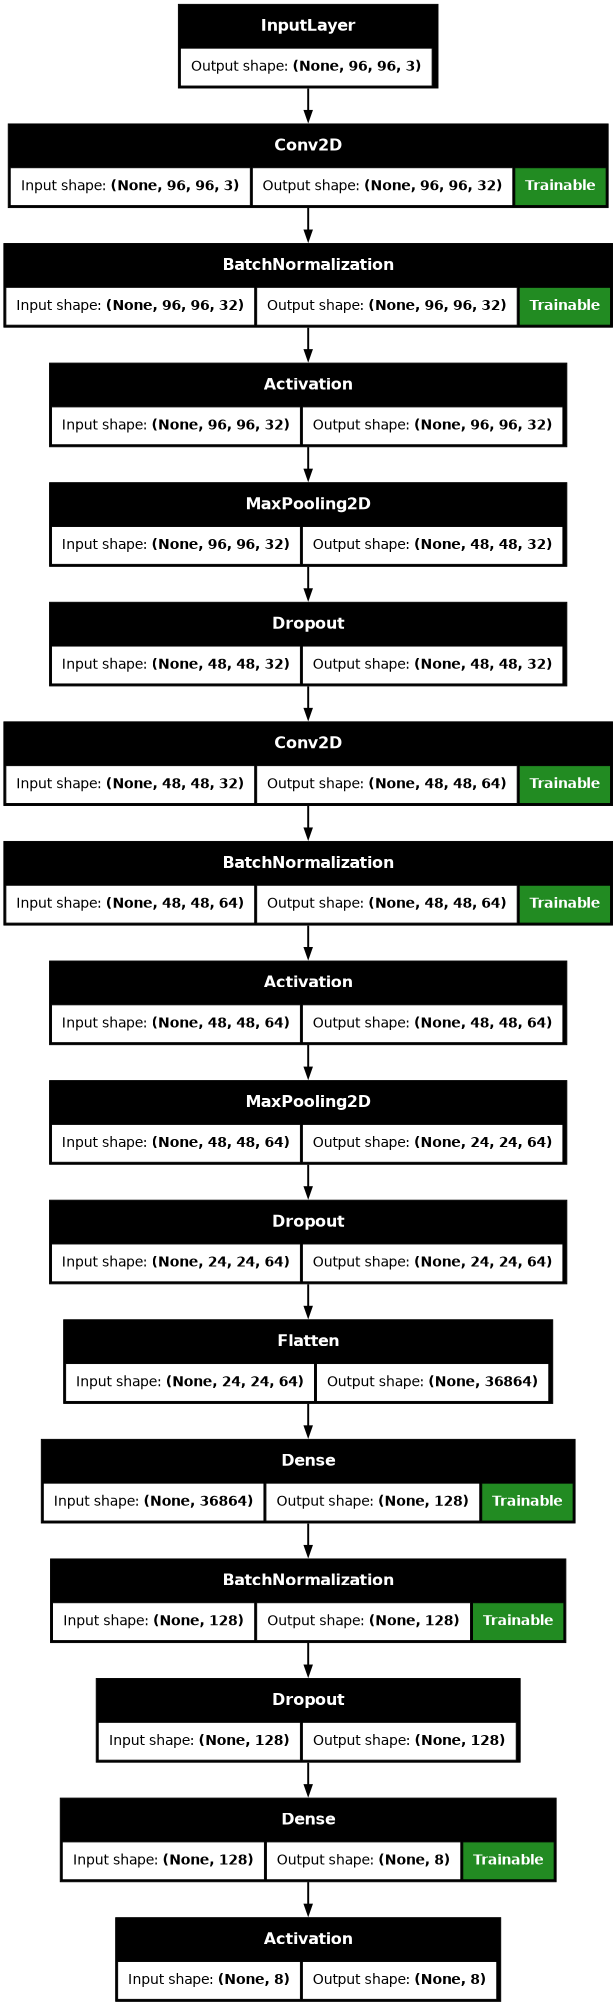

In [8]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [9]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Metric to monitor
    mode='max',                   # Mode ('max' for accuracy)
    patience=20,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True     # Restore the model weights from the epoch with the best value of the monitored metric
)

In [10]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Metric to monitor
    factor=0.5,                   # Factor by which the learning rate will be reduced
    patience=5,                   # Number of epochs with no improvement before reducing learning rate
    verbose=1,                    # Verbosity mode (0 = silent, 1 = updates messages)
    min_lr=1e-6                   # Lower bound on the learning rate
)

In [11]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'regularizedCNN_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200


I0000 00:00:1732433337.879717      97 service.cc:145] XLA service 0x7d4b1400f5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732433337.879796      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 15/337 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1516 - loss: 2.8927

I0000 00:00:1732433344.617330      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.2205 - loss: 2.2160 - val_accuracy: 0.2731 - val_loss: 1.8688 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3601 - loss: 1.7177 - val_accuracy: 0.3637 - val_loss: 1.7165 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4161 - loss: 1.5704 - val_accuracy: 0.3134 - val_loss: 1.9144 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4512 - loss: 1.4873 - val_accuracy: 0.3700 - val_loss: 1.6974 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4725 - loss: 1.4333 - val_accuracy: 0.4214 - val_loss: 1.5566 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4990 - loss: 1.3656 - val_accuracy: 0.4470 - val_loss: 1.4886 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5144 - loss: 1.3152

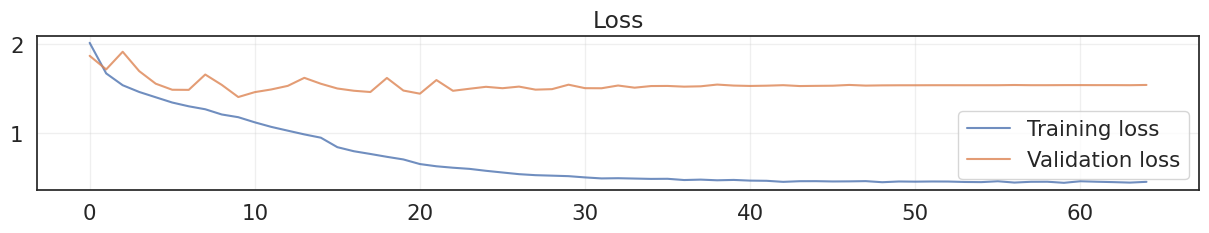

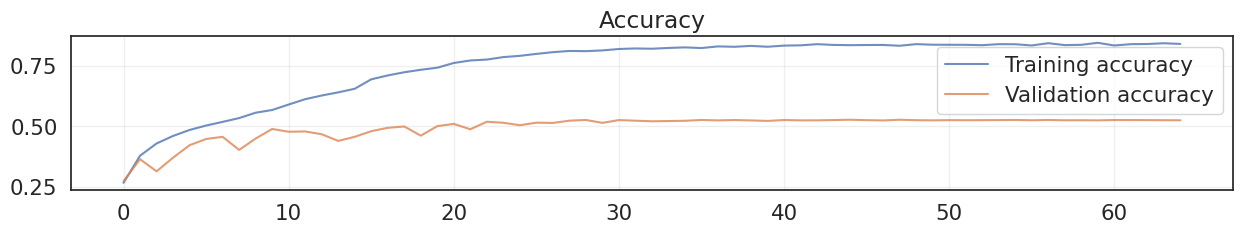

In [12]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 🕹️ Use the Model - Make Inference

Model: "regularized_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ bn1 (BatchNormalization)    │ (None, 96, 96, 32)    │        128 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout1 (Dropout)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ bn2 (BatchNormalization)    │ (None, 48, 48, 64)    │        256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout2 (Dropout)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense1 (Dense)              │ (None, 128)           │  4,718,720 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ bn3 (BatchNormalization)    │ (None, 128)           │        512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout3 (Dropout)          │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense2 (Dense)              │ (None, 8)             │      1,032 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,219,226 (54.24 MB)

 Trainable params: 4,739,592 (18.08 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 9,479,186 (36.16 MB)

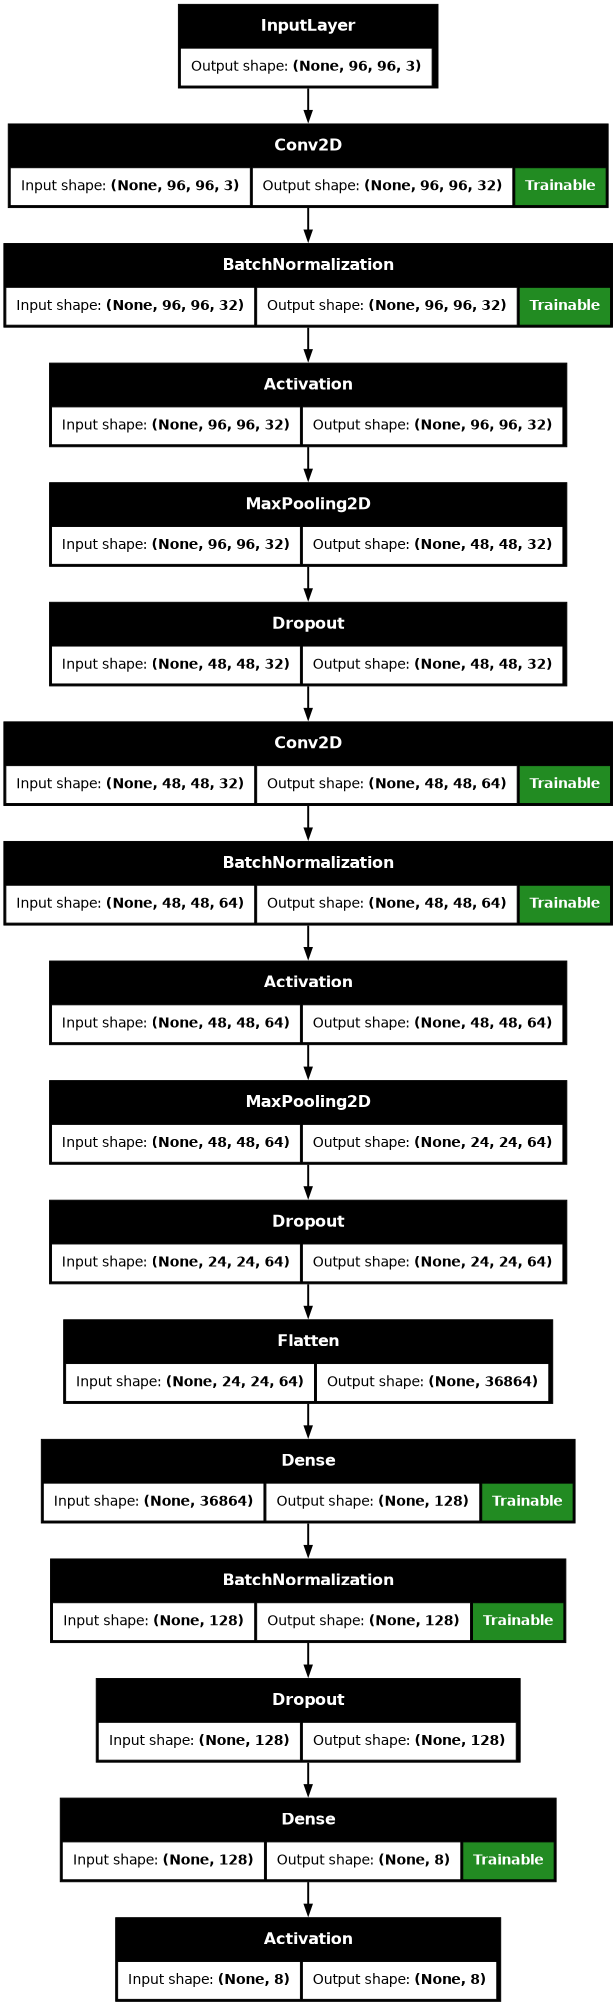

In [15]:
# Load the saved model
regularized = tfk.models.load_model('/kaggle/working/regularizedCNN_52.66.keras')

# Display a summary of the model architecture
regularized.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(regularized, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

### Test model on test set

#### 1. Test set without augmentation

Accuracy score over the test set: 0.7988
Precision score over the test set: 0.8309
Recall score over the test set: 0.7988
F1 score over the test set: 0.7825


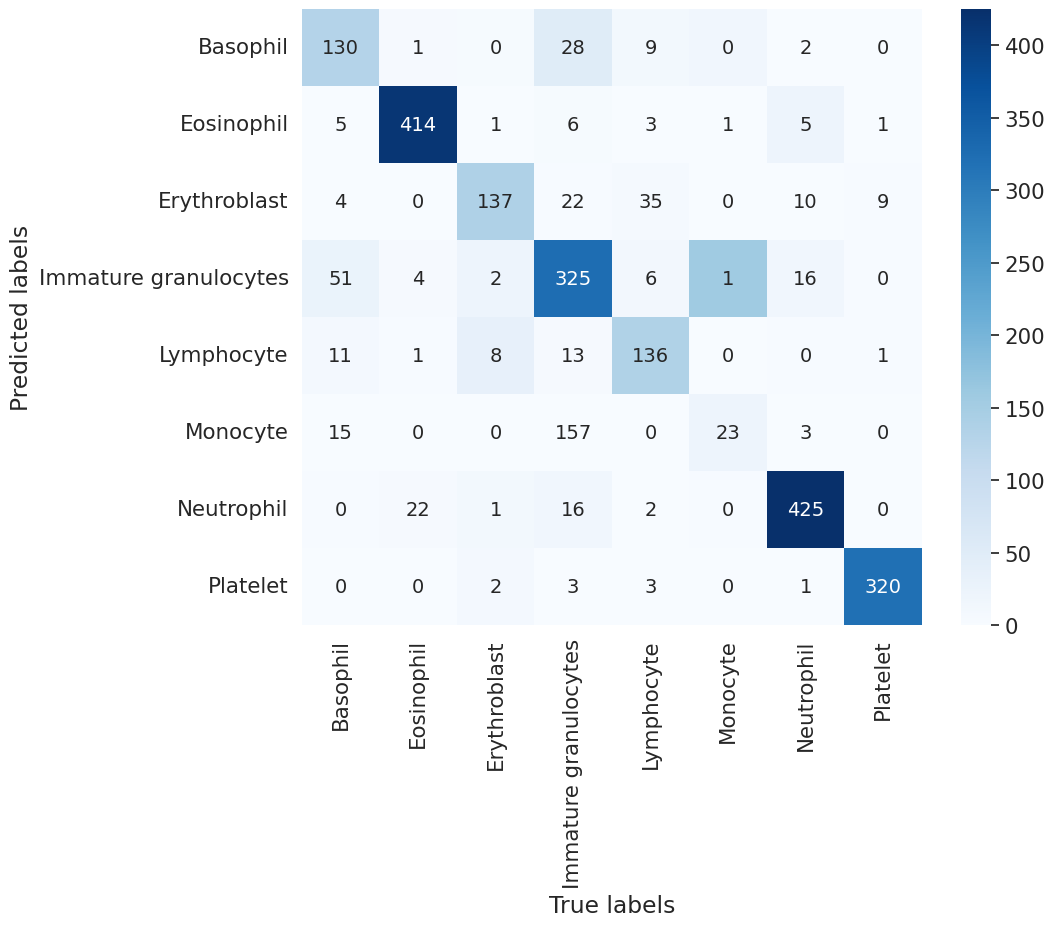

In [16]:
# Predict labels for the entire test set
predictions = regularized.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 2. Test set with augmentation

Accuracy score over the test set augmented: 0.4219
Precision score over the test set augmented: 0.4194
Recall score over the test set augmented: 0.4219
F1 score over the test set augmented: 0.4065


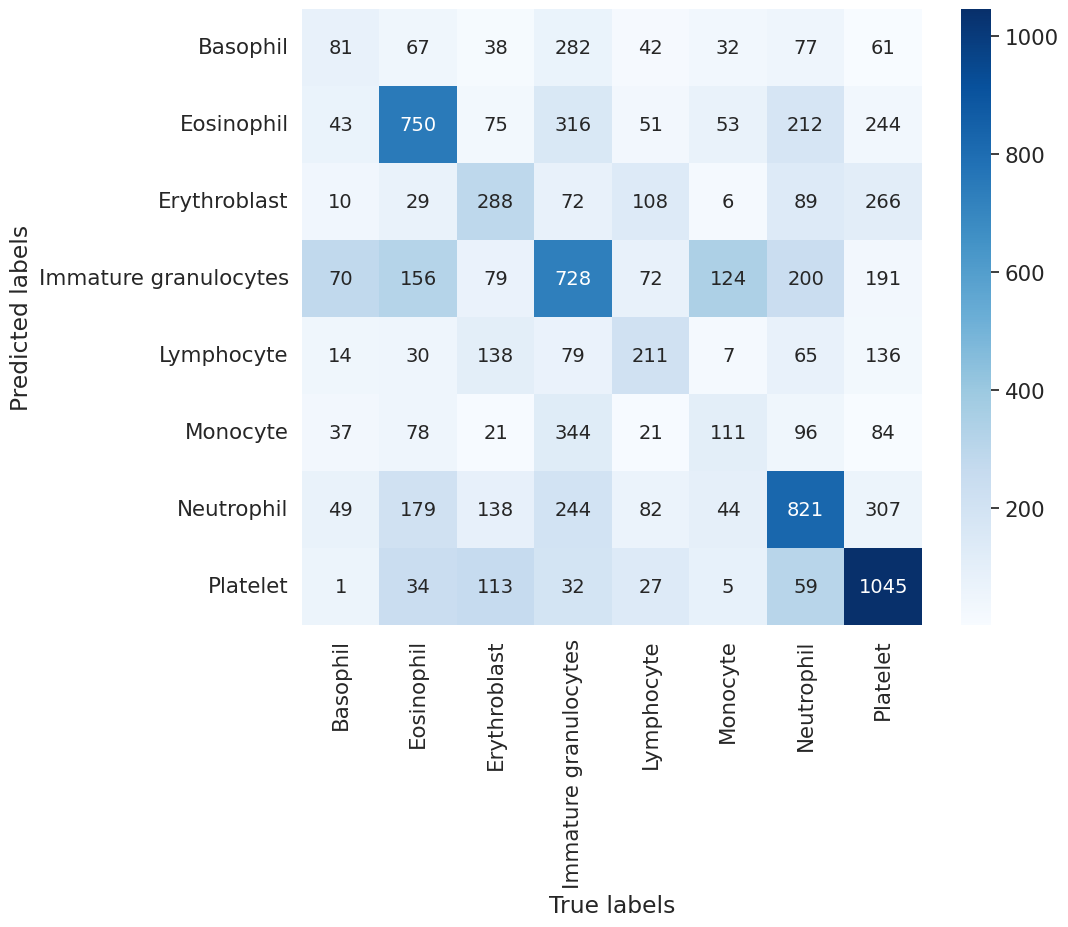

In [17]:
# Predict labels for the entire test set
predictions_aug = regularized.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes_aug = np.argmax(predictions_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy_aug = accuracy_score(true_classes_aug, pred_classes_aug)
print(f'Accuracy score over the test set augmented: {round(accuracy_aug, 4)}')

# Calculate and display test set precision
precision_aug = precision_score(true_classes_aug, pred_classes_aug, average='weighted')
print(f'Precision score over the test set augmented: {round(precision_aug, 4)}')

# Calculate and display test set recall
recall_aug = recall_score(true_classes_aug, pred_classes_aug, average='weighted')
print(f'Recall score over the test set augmented: {round(recall_aug, 4)}')

# Calculate and display test set F1 score
f1_aug = f1_score(true_classes_aug, pred_classes_aug, average='weighted')
print(f'F1 score over the test set augmented: {round(f1_aug, 4)}')

# Compute the confusion matrix
cm_aug = confusion_matrix(true_classes_aug, pred_classes_aug)

# Combine numbers and percentages into a single string for annotation
annot_aug = np.array([f"{num}" for num in cm_aug.flatten()]).reshape(cm_aug.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug.T, annot=annot_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python

# file: model.py

import tensorflow as tf
import numpy as np

class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

        # Load the pre-trained model weights
        self.model = tf.keras.models.load_model('weights.keras')  # Path to your saved weights

    def predict(self, X):
        """
        Return a numpy array with the labels corresponding to the input X.
        X: numpy array of input images.
        """
        predictions = self.model.predict(X)
        # Return the class labels as a numpy array
        return np.argmax(predictions, axis=-1)

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [1]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        """
        # Load the specific model file
        self.neural_network = tfk.models.load_model('regularizedCNN_52.66.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        This function returns class labels as integers.
        """
        # Get predictions and convert to label format
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [2]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py regularizedCNN_52.66.keras

  adding: model.py (deflated 52%)
  adding: regularizedCNN_52.66.keras (deflated 22%)
